In [5]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [6]:
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import matplotlib.pyplot as plt

### I. Setup display settings for plotting

In [7]:
# Display settings
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 11})
plt.style.use('fivethirtyeight')

### II. Reading and setting up the data

In [8]:
train_path = Path('./train.csv')
test_path = Path('./test.csv')

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
print('Train data shape:', train_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (957919, 120)
Test data shape: (493474, 119)


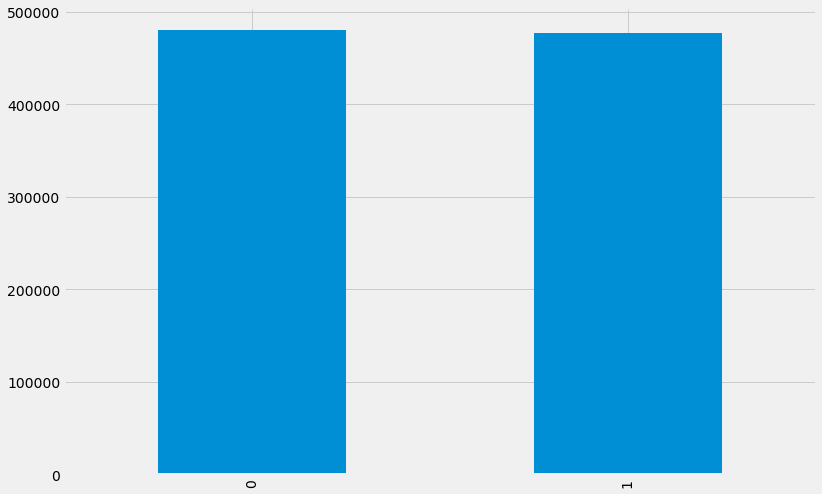

In [9]:
train_data['claim'].value_counts().plot.bar()
plt.show()

### III. Data Processing

In [10]:
train_data.dtypes

id         int64
f1       float64
f2       float64
f3       float64
f4       float64
          ...   
f115     float64
f116     float64
f117     float64
f118     float64
claim      int64
Length: 120, dtype: object

In [11]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_data))
splits

((#766336) [534766,740479,127418,837762,427532,885668,790601,691407,766603,128705...],
 (#191583) [291541,400890,644624,439465,13000,837910,180134,79419,515169,932942...])

**Note:**

            cont_names: Your continuous x variables
            y_names: Your dependent y variables
            y_block: How to sub-categorize the type of y_names (CategoryBlock or RegressionBlock)
            splits: How to split your data

In [12]:
cont_names = list(train_data.iloc[:, 1:-1])
procs = [Categorify, FillMissing, Normalize]
y_names = 'claim'
y_block = CategoryBlock()

In [13]:
to = TabularPandas(train_data, cont_names=cont_names, procs=procs, y_names=y_names, y_block=y_block, splits=splits)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [14]:
to.cont_names

(#118) ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'...]

In [15]:
to.show()

,f1_na,f2_na,f3_na,f4_na,f5_na,f6_na,f7_na,f8_na,f9_na,f10_na,f11_na,f12_na,f13_na,f14_na,f15_na,f16_na,f17_na,f18_na,f19_na,f20_na,f21_na,f22_na,f23_na,f24_na,f25_na,f26_na,f27_na,f28_na,f29_na,f30_na,f31_na,f32_na,f33_na,f34_na,f35_na,f36_na,f37_na,f38_na,f39_na,f40_na,f41_na,f42_na,f43_na,f44_na,f45_na,f46_na,f47_na,f48_na,f49_na,f50_na,f51_na,f52_na,f53_na,f54_na,f55_na,f56_na,f57_na,f58_na,f59_na,f60_na,f61_na,f62_na,f63_na,f64_na,f65_na,f66_na,f67_na,f68_na,f69_na,f70_na,f71_na,f72_na,f73_na,f74_na,f75_na,f76_na,f77_na,f78_na,f79_na,f80_na,f81_na,f82_na,f83_na,f84_na,f85_na,f86_na,f87_na,f88_na,f89_na,f90_na,f91_na,f92_na,f93_na,f94_na,f95_na,f96_na,f97_na,f98_na,f99_na,f100_na,f101_na,f102_na,f103_na,f104_na,f105_na,f106_na,f107_na,f108_na,f109_na,f110_na,f111_na,f112_na,f113_na,f114_na,f115_na,f116_na,f117_na,f118_na,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
534766,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.050046,0.33575,1769.800049,0.010284,0.32856,-1.301800,346.010010,7.288800e+05,3.309400e+14,25891.000000,-1.469800,-5.227264e+06,0.24881,10.365000,0.078248,14.149994,6.2156,2.0262,15.522000,123.970001,299750.000000,2.2557,111.150002,1.3988,37.125977,1.455600e+13,2.974400e+11,3093800.0,0.901660,2.4341,0.49322,-19652.000000,684410.0,-0.000563,1.608100e+16,-1008.900085,192.750000,1.5295,1673.500000,0.000320,8.383301,0.088152,6.1548,29.142000,0.006233,3.718400,0.53597,4.4243,-0.718845,0.16396,23.185001,1057.400024,29.497000,152.080002,0.001404,0.54378,0.000174,-0.28775,3.4427,0.569000,0.011651,3.539507e+07,50.219002,0.586860,12838.000000,67.625000,908.349976,104.059998,1.5273,-0.000735,1.6390,787.989990,-2.394377e+12,3.077308e+09,-0.003352,5.5379,3008.299316,1068.700195,-1.521500,0.219820,3.01080,1.169800e+10,232.880005,13935000.0,1774.699951,7.795200e+10,96.584991,167.589996,1432.099854,6.2708,0.487930,-292.399902,40.293999,1.177600,22.416000,22721.000000,0.99857,-1.836403e+11,1.5799,0.65619,52.286995,128290.0,31.252960,178.000000,0.036394,0.578840,0.008597,-9.762816e+06,0.935860,-11.720000,1.44500,0.539080,22.84100,5063.894531,1.0952,2.448101e+15,2534.800049,1.82150,1
740479,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0.108800,0.26460,4404.299805,0.425210,0.34959,-1.192800,2278.500

In [16]:
dls = to.dataloaders()

In [13]:
dls

### V. Creating the Decision Tree

In [22]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [15]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

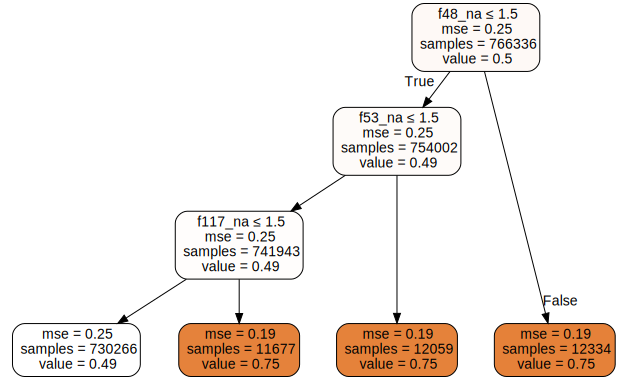

In [16]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

The top node represents the initial model before any splits have been done, when all the data is in one group.
(This is the simplest possible model)
It is the result of asking zero questions and will always predict the value to be the average value of the whole dataset. It predicts a value of 0.5.
We also see that there are 760,000 insurance claims - the total size of our training set.
The decision criterion for the best split that was found was based on 'f48' column

Moving down to the left, it found 750,000 claims that were <= 1.5. The average value of our dependent variable in this group is 0.49. The right shows us where f48 > 1.5 and there were 12,000 claims.

The bottom row contains our leaf nodes: the nodes with no answers coming out of them, because there are no more questions to be answered. Asking only about f48 predicts an average value of 0.75 versus 0.5

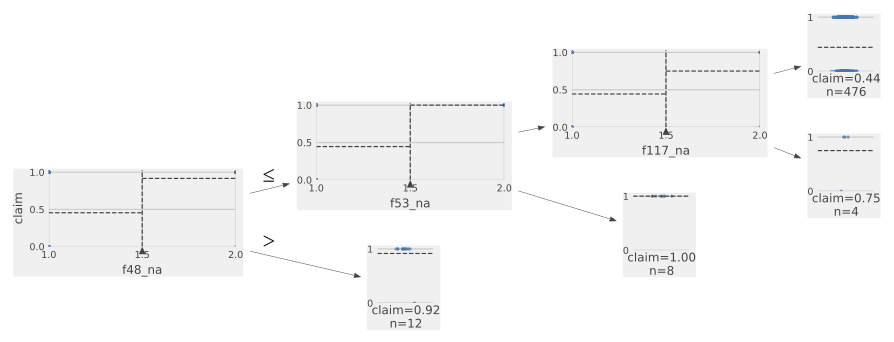

In [17]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, 'claim',
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

This shows a chart of the distribution of the data for each split point.

Lets now have the decision tree algorithm build a bigger tree.

We'll create a little function to check the root mean squared error of our model (m_rmse)

In [20]:
def r_mse(pred,y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 auction records:

In [19]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.352624, 0.464091)

In [20]:
m.get_n_leaves()

20230

### VI. Creating a Random Forest


We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

- n_estimators defines the number of trees we want
- max_samples defines how many rows to sample for training each tree
- max_features defines how many columns to sample at each split point (where 0.5 means "take half the total number of columns")
- We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same min_samples_leaf parameter we used in the last section
- Finally, we pass n_jobs=-1 to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [17]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [22]:
m = rf(xs, y)

In [55]:
save_pickle(Path('./m.pkl'), m)

Loading the model

In [18]:
m = load_pickle(Path('./m.pkl'))

In [23]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.35232, 0.415638)

In [24]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [25]:
r_mse(preds.mean(0), valid_y)

0.415638

Let's see what happens to the RMSE as we add more and more trees. As you can see, the improvement levels off quite a bit after around 30 trees:

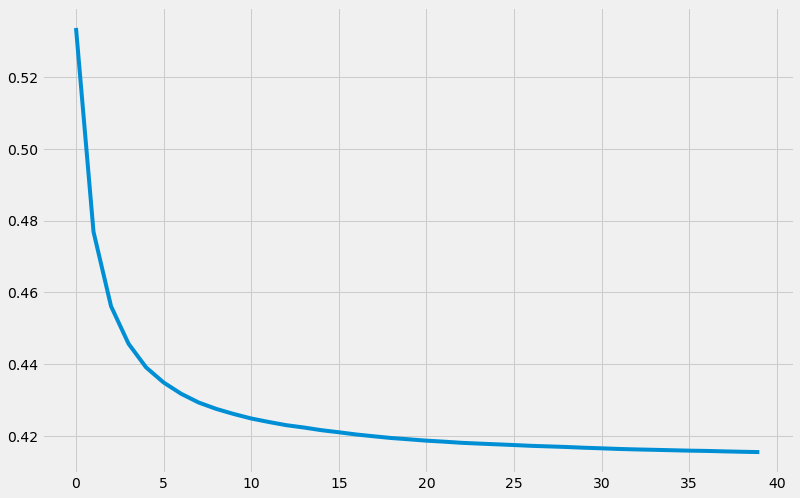

In [26]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both? With the existing information we've seen, we can't tell. However, random forests have a very clever trick called out-of-bag (OOB) error that can help us with this (and more!).

### VII. Out-of-Bag Error

Recall that in a random forest, each tree is trained on a different subset of the training data. The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was not included in training. This allows us to see whether the model is overfitting, without needing a separate validation set

The OOB predictions are available in the oob_prediction_ attribute. Note that we compare them to the training labels, since this is being calculated on trees using the training set.

In [27]:
r_mse(m.oob_prediction_, y)

0.415957

### VIII. Using a Neural Network

In [30]:
dls = to.dataloaders(1024)

In [31]:
y = to.train.y
y.min(),y.max()

(0, 1)

metrics is an optional list of metrics, that can be either functions or Metrics (see below).
Metrics can be simple averages (like accuracy) but sometimes their computation is a little bit more complex and can't be averaged over batches (like precision or recall), which is why we need a special class for them.

In [32]:
# learn = tabular_learner(dls, y_range=(0,1), layers=[500,250],
#                         n_out=1, loss_func=F.mse_loss)

learn = tabular_learner(dls, layers=[500, 250, 125],
                        metrics=[accuracy, error_rate, Recall(), Precision()])

In [33]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(3, 3)
    (21): Embedding(3, 3)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
    (24): Embedding(3, 3)
    (25): Embedding(3, 3)
    (26): Embedding(3, 3)
    (27): Embedding(3, 3)
    (28): Embedding(3, 3)
    (29): Embedding(3, 3)
    (30): Embedding(3, 3)
    (31): Embedding(3, 3)
    (32): Embedding(3, 3)
    (33): Embedding(3, 3)
    (34): Embedding(3, 3)
    (35): Embedding(3, 3)
    (36): Embedding(3, 3)
    (37): 

SuggestedLRs(valley=0.0005754399462603033)

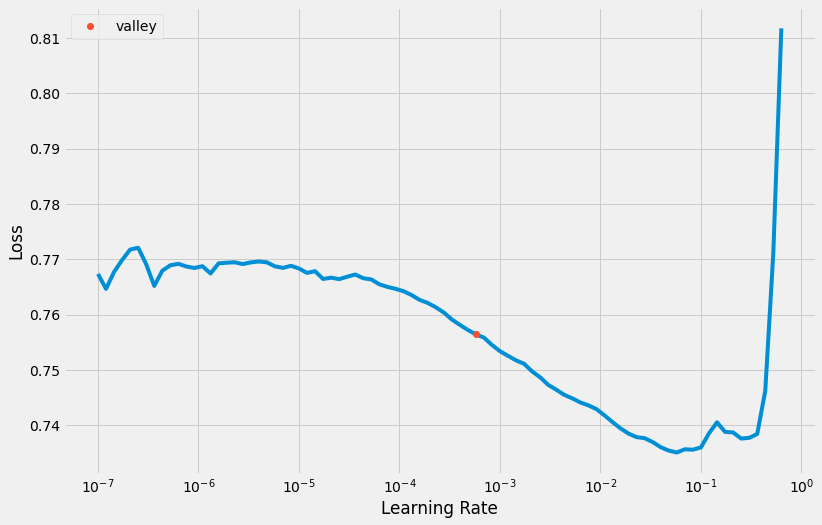

In [34]:
learn.lr_find()

In [35]:
learn.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,time
0,0.511548,0.517734,0.767135,0.232865,0.860233,0.724275,00:23
1,0.514924,0.514470,0.770293,0.229707,0.892030,0.716505,00:23
2,0.511466,0.520398,0.769651,0.230349,0.886594,0.717664,00:23
3,0.513387,0.514343,0.770152,0.229848,0.889548,0.717209,00:23
4,0.513956,0.514811,0.770194,0.229806,0.892669,0.716169,00:23


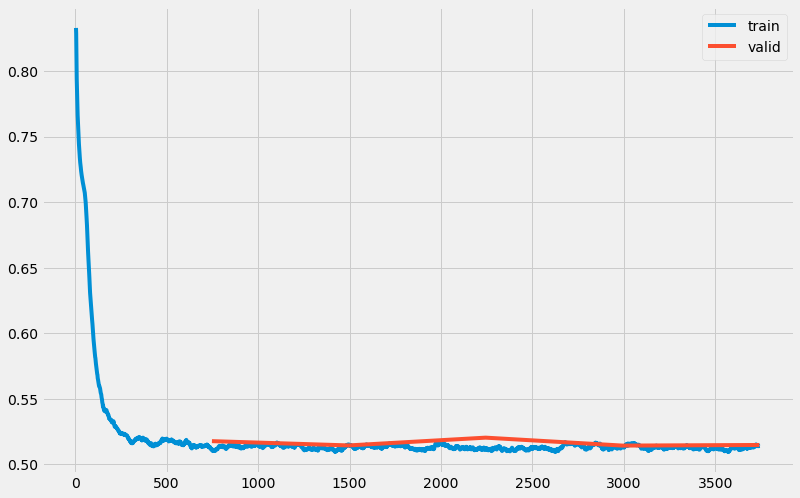

In [36]:
learn.recorder.plot_loss()

In [38]:
dl = learn.dls.test_dl(test_data)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


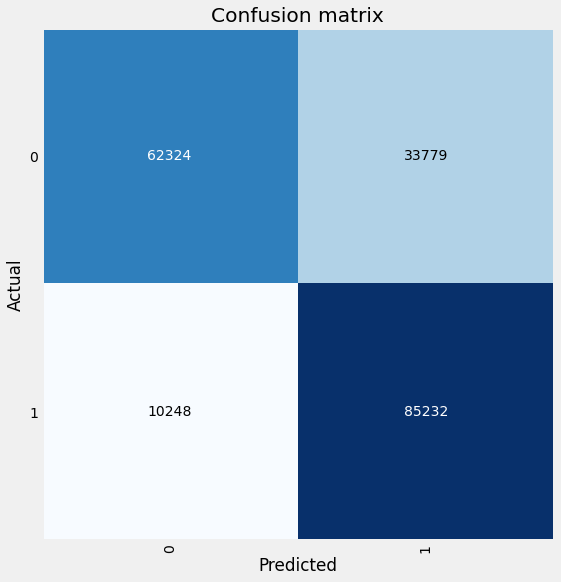

In [39]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

In [40]:
preds = learn.get_preds(dl=dl)

In [41]:
type(preds)

tuple

In [42]:
preds

(tensor([[0.4149, 0.5851],
         [0.8974, 0.1026],
         [0.4417, 0.5583],
         ...,
         [0.2483, 0.7517],
         [0.9147, 0.0853],
         [0.2661, 0.7339]]),
 None)

In [47]:
final_preds = preds[0].numpy()[:, 1]

In [48]:
submission_df = pd.read_csv(Path("./sample_solution.csv"))

In [49]:
submission_df

,id,claim
0,957919,0.5
1,957920,0.5
2,957921,0.5
3,957922,0.5
4,957923,0.5
...,...,...
493469,1451388,0.5
493470,1451389,0.5
493471,1451390,0.5
493472,1451391,0.5


In [50]:
submission_df['claim'] = final_preds

In [51]:
submission_df

,id,claim
0,957919,0.585123
1,957920,0.102613
2,957921,0.558267
3,957922,0.109030
4,957923,0.113313
...,...,...
493469,1451388,0.782087
493470,1451389,0.097231
493471,1451390,0.751685
493472,1451391,0.085338
